## Load Dataset and Create 20 Samples in SKIN_samples

In [1]:
import pandas as pd
import os
import shutil
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import onnx
import onnxruntime as ort
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# ---------- Configuration ----------
image_dir = "Dataset/HAM10000_images"
metadata_path = "Dataset/HAM10000_metadata.csv"
sample_dir = "Dataset/SKIN_sample"
os.makedirs(sample_dir, exist_ok=True)

In [3]:
# ---------- Load and Prepare Metadata ----------
df = pd.read_csv(metadata_path)
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))

label_map = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis-like Lesions',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma'
}
df['label_name'] = df['dx'].map(label_map)

# Filter out missing image files
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# ---------- Stratified 20-sample split ----------
sample_df, _ = train_test_split(
    df,
    train_size=20,
    stratify=df['label_name'],
    random_state=42
)

In [4]:
for i, row in sample_df.iterrows():
    src = row['image_path']
    dst = os.path.join(sample_dir, f"{row['image_id']}.jpg")
    shutil.copy(src, dst)

# Update image_path to SKIN_sample folder
sample_df['image_path'] = sample_df['image_id'].apply(lambda x: os.path.join(sample_dir, f"{x}.jpg"))

# ---------- Save CSV ----------
sample_df.to_csv(os.path.join(sample_dir, "SKIN_sample.csv"), index=False)



In [5]:
# ---------- Optional: Show label distribution ----------
sample_df['label_name'].value_counts()

label_name
Melanocytic Nevi                 14
Melanoma                          2
Benign Keratosis-like Lesions     2
Actinic Keratoses                 1
Basal Cell Carcinoma              1
Name: count, dtype: int64

In [6]:
sample_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,label_name
3260,HAM_0002632,ISIC_0029943,nv,follow_up,50.0,female,genital,Dataset/SKIN_sample/ISIC_0029943.jpg,Melanocytic Nevi
7095,HAM_0005159,ISIC_0029826,nv,histo,50.0,male,back,Dataset/SKIN_sample/ISIC_0029826.jpg,Melanocytic Nevi
2141,HAM_0006037,ISIC_0026571,mel,histo,40.0,female,chest,Dataset/SKIN_sample/ISIC_0026571.jpg,Melanoma
7309,HAM_0003507,ISIC_0032784,nv,histo,30.0,male,lower extremity,Dataset/SKIN_sample/ISIC_0032784.jpg,Melanocytic Nevi
4185,HAM_0005210,ISIC_0025965,nv,follow_up,50.0,male,trunk,Dataset/SKIN_sample/ISIC_0025965.jpg,Melanocytic Nevi


## Model Evaluation

In [7]:
def preprocess_sample_data(sample_dir="Dataset/SKIN_sample", image_size=224):
    import pandas as pd, numpy as np, os
    from PIL import Image

    # 1) Load sample metadata
    df = pd.read_csv(os.path.join(sample_dir, "SKIN_sample.csv"))
    df['image_path'] = df['image_id'].apply(lambda x: os.path.join(sample_dir, f"{x}.jpg"))

    # 2) Load & normalize images
    X_img = []
    for img_id in df['image_id']:
        img = Image.open(os.path.join(sample_dir, f"{img_id}.jpg"))\
                   .convert("RGB").resize((image_size, image_size))
        X_img.append(np.array(img, np.float32) / 255.0)
    X_img = np.stack(X_img, axis=0)

    # 3) Prepare metadata
    meta_df = df[['age', 'sex', 'localization']].copy()
    meta_df['age'].fillna(meta_df['age'].mean(), inplace=True)

    # 4) Define full category lists exactly as in training
    sex_categories = ['male', 'female']  # training saw only these two
    # You must replace this list with the full set of localizations seen in training:
    loc_categories = ['abdomen', 'acral', 'back', 'chest', 'ear', 'face', 'foot',
                      'genital', 'hand', 'lower extremity', 'neck', 'scalp',
                      'trunk', 'unknown', 'upper extremity']

    # 5) Build a ColumnTransformer with fixed categories
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), ['age']),
        ('cat', OneHotEncoder(categories=[sex_categories, loc_categories],
                              handle_unknown='ignore'),
         ['sex', 'localization'])
    ])

    # 6) Transform metadata—no fitting on the small sample
    X_meta = preprocessor.fit_transform(meta_df).astype(np.float32)
    
    if hasattr(X_meta, "toarray"):
        X_meta = X_meta.toarray()
    X_meta = np.asarray(X_meta, dtype=np.float32)

    # 7) True labels
    y_true = df['label_name'].tolist()

    return X_img, X_meta, y_true

### Load the dataset

In [8]:
# Call the preprocessing function to load the data
X_img, X_meta, y_true = preprocess_sample_data()



/tmp/ipykernel_240752/3023666417.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  meta_df['age'].fillna(meta_df['age'].mean(), inplace=True)


### Load ONNX

In [9]:
# Load the ONNX model
onnx_path = "Models/SKIN_72.onnx"
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

### Inference

In [10]:
ort_session = ort.InferenceSession(onnx_path)

# ── Prepare inputs ──
input_names = [inp.name for inp in ort_session.get_inputs()]
# e.g. ['image_input', 'meta_input']
feed = {
    input_names[0]: X_img,
    input_names[1]: X_meta
}

# ── Run inference ──
y_pred_probs = ort_session.run(None, feed)[0]
y_pred = np.argmax(y_pred_probs, axis=1)

# 1) Define the full, original class list in the same order used at training
class_names = [
    'Actinic Keratoses',
    'Basal Cell Carcinoma',
    'Benign Keratosis-like Lesions',
    'Dermatofibroma',
    'Melanocytic Nevi',
    'Melanoma',
    'Vascular Lesions'
]

# 2) Encode y_true against that full list
y_true_enc = np.array([ class_names.index(lbl) for lbl in y_true ], dtype=int)

### Results


                               precision    recall  f1-score   support

            Actinic Keratoses       0.00      0.00      0.00         1
         Basal Cell Carcinoma       0.33      1.00      0.50         1
Benign Keratosis-like Lesions       0.25      0.50      0.33         2
               Dermatofibroma       0.00      0.00      0.00         0
             Melanocytic Nevi       1.00      0.57      0.73        14
                     Melanoma       0.25      0.50      0.33         2
             Vascular Lesions       0.00      0.00      0.00         0

                     accuracy                           0.55        20
                    macro avg       0.26      0.37      0.27        20
                 weighted avg       0.77      0.55      0.60        20



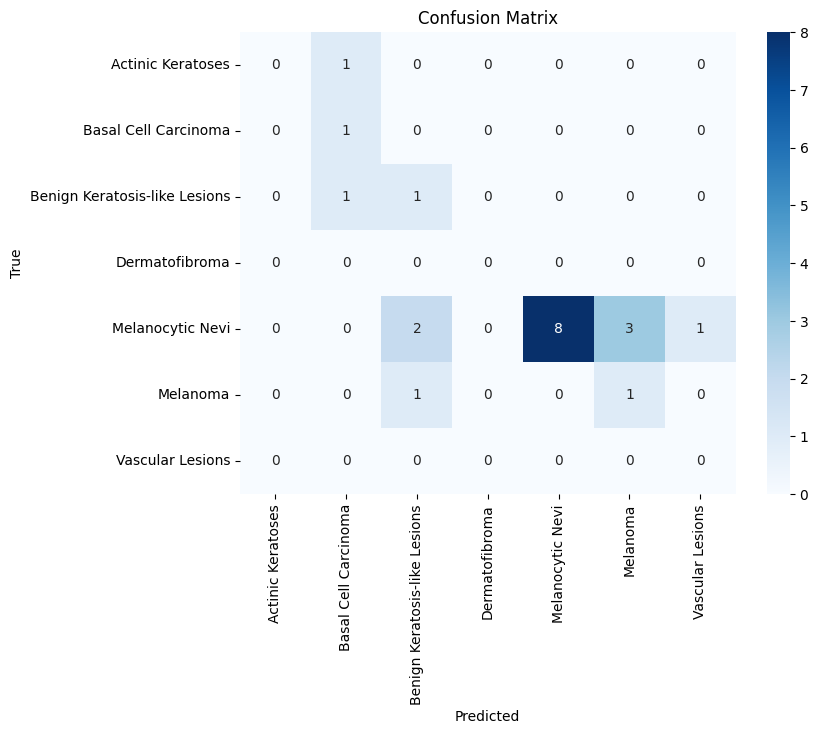

In [11]:
print(classification_report(
    y_true_enc, 
    y_pred, 
    labels=list(range(len(class_names))), 
    target_names=class_names,
    zero_division=0       # avoids warnings if a class has zero preds
))

# 5) And plot the confusion matrix
cm = confusion_matrix(y_true_enc, y_pred, labels=list(range(len(class_names))))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# ---------- Optional: Show label distribution ----------
sample_df['label_name'].value_counts()

label_name
Melanocytic Nevi                 14
Melanoma                          2
Benign Keratosis-like Lesions     2
Actinic Keratoses                 1
Basal Cell Carcinoma              1
Name: count, dtype: int64